### **[SciBERT](http://github.com/allenai/scibert)** 
* It is a BERT model trained on scientific text.<br>
* SciBERT is trained on papers from the corpus of semanticscholar.org. Corpus size is 1.14M papers, 3.1B tokens. We use the full text of the papers in training, not just abstracts.

### Multi Class vs Multi Label Classification
* **Multi Class** - There are multiple categories but each instance is assigned only one, therefore such problems are known as multi-class classification problem.
* **Multi Label** - There are multiple categories and each instance can be assigned with multiple categories, so these types of problems are known as multi-label classification problem, where we have a set of target labels.

### Dual Input
The dataset contains two texts - **Title** & **Abstract**. In this notebook, we'll try out 2 different architectures (modifications/additions to the pure SciBERT model) that handle multi textual input.
1. Dual SciBERT<br>
![Dual SciBERT](https://miro.medium.com/max/1400/1*VAGuT28ban70hwbqZxEGjw.png)
<br>
2. Siamese SciBERT<br>
![Siamese SciBERT](https://miro.medium.com/max/1400/1*K8-8INIsJQZ2s3OWtlllBg.png)

# Imports

The entire code is written using **PyTorch**.<br>
We'll be using the **transformers** library by [huggingface](https://github.com/huggingface/transformers) as they provide wrappers for multiple Transformer models.

In [1]:
# ! pip3 install transformers

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup
)

project_dir = '../input/avjanatahackresearcharticlesmlc/av_janatahack_data/'

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Checking the GPU configurations. Kaggle's Tesla P100 GPU proves to be much faster for finetuning SciBERT on this dataset as compared to Google Colab's Tesla K80.

In [3]:
! nvidia-smi

Mon Aug 24 13:24:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Data

We're using just the abstract text, but concatenating the title text along with it performed better on the leaderboard. 
<br><br>
## Preprocessing
- Stripping extra whitespaces around the text.
- Replacing escape characters with whitespace.
- Padding all punctuations with whitespaces on both sides.

#### Additional Tips:
- Replacing Latex equations with a special token.
- Data Augmentation. 



In [4]:
train_df = pd.read_csv(project_dir + 'train.csv')
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
# preprocessing
def clean_text(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text
    

def get_texts(df):
    titles = df['TITLE'].apply(clean_text)
    titles = titles.values.tolist()
    abstracts = df['ABSTRACT'].apply(clean_text)
    abstracts = abstracts.values.tolist()
    return titles, abstracts


def get_labels(df):
    labels = df.iloc[:, 3:].values
    return labels

titles, abstracts = get_texts(train_df)
labels = get_labels(train_df)

for t, a, l in zip(titles[:5], abstracts[:5], labels[:5]):
    print(f'TITLE -\t{t}')
    print(f'ABSTRACT -\t{a}')
    print(f'LABEL -\t{l}')
    print('_' * 80)
    print()

TITLE -	Reconstructing Subject-Specific Effect Maps
ABSTRACT -	Predictive models allow subject-specific inference when analyzing disease related alterations in neuroimaging data .  Given a subject's data ,  inference can be made at two levels: global ,  i . e .  identifiying condition presence for the subject ,  and local ,  i . e .  detecting condition effect on each individual measurement extracted from the subject's data .  While global inference is widely used ,  local inference ,  which can be used to form subject-specific effect maps ,  is rarely used because existing models often yield noisy detections composed of dispersed isolated islands .  In this article ,  we propose a reconstruction method ,  named RSM ,  to improve subject-specific detections of predictive modeling approaches and in particular ,  binary classifiers .  RSM specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers .  The proposed method i

## Exploratory Data Analysis

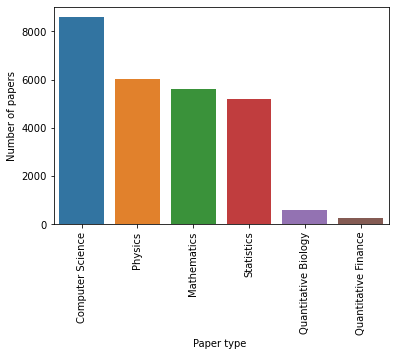

In [6]:
# no. of samples for each class
categories = train_df.columns.to_list()[3:]
plt.figure(figsize=(6, 4))

ax = sns.barplot(categories, train_df.iloc[:, 3:].sum().values)
plt.ylabel('Number of papers')
plt.xlabel('Paper type ')
plt.xticks(rotation=90)
plt.show()

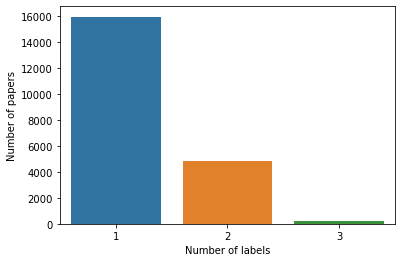

In [7]:
# no of samples having multiple labels
row_sums = train_df.iloc[:, 3:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.ylabel('Number of papers')
plt.xlabel('Number of labels')
plt.show()

<BarContainer object of 20972 artists>

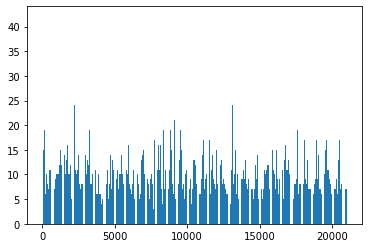

In [8]:
# title lengths
y = [len(t.split()) for t in titles]
x = range(0, len(y))
plt.bar(x, y)

<BarContainer object of 20972 artists>

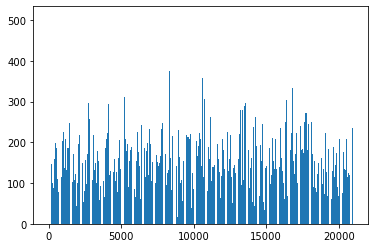

In [9]:
# abstracts lengths
y = [len(t.split()) for t in abstracts]
x = range(0, len(y))
plt.bar(x, y)

From the plots above we can infer that, **20** seems like a good choice for **titles MAX_LENGTH** and **320** for **abstracts MAX_LENGTH**.

# Config

Here we define a Config class, which contains all the fixed parameters & hyperparameters required for **Dataset** creation as well as **Model** training.

In [10]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'allenai/scibert_scivocab_uncased'
        self.NUM_LABELS = 6

        # data
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH1 = 20
        self.MAX_LENGTH2 = 320
        self.BATCH_SIZE = 5
        self.VALIDATION_SPLIT = 0.25

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 1

config = Config()

# Dataset & Dataloader

Now, we'll create a custom Dataset class inherited from the PyTorch Dataset class. We'll be using the **SciBERT tokenizer** that returns **input_ids** and **attention_mask**.<br><br>
The custom Dataset class will return a dict containing - <br>

- titles
    - input_ids
    - attention_mask
- abstracts
    - input_ids
    - attention_mask
- labels
    
<br>

In [11]:
class TransformerDataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset, self).__init__()

        df = df.iloc[indices]
        self.titles, self.abstracts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.max_length1 = config.MAX_LENGTH1
        self.max_length2 = config.MAX_LENGTH2
        self.tokenizer = config.TOKENIZER

    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, index):
        tokenized_titles = self.tokenizer.encode_plus(
            self.titles[index], 
            max_length=self.max_length1,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        input_ids_titles = tokenized_titles['input_ids'].squeeze()
        attention_mask_titles = tokenized_titles['attention_mask'].squeeze()
        
        tokenized_abstracts = self.tokenizer.encode_plus(
            self.abstracts[index], 
            max_length=self.max_length2,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        input_ids_abstracts = tokenized_abstracts['input_ids'].squeeze()
        attention_mask_abstracts = tokenized_abstracts['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'titles': {
                    'input_ids': input_ids_titles.long(),
                    'attention_mask': attention_mask_titles.long(),
                },
                'abstracts': {
                    'input_ids': input_ids_abstracts.long(),
                    'attention_mask': attention_mask_abstracts.long(),
                },
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'titles': {
                'input_ids': input_ids_titles.long(),
                'attention_mask': attention_mask_titles.long(),
            },
            'abstracts': {
                'input_ids': input_ids_abstracts.long(),
                'attention_mask': attention_mask_abstracts.long(),
            }
        }

Our **TransformerDataset** Class takes as input the **dataframe**, **indices** & **set_type**. We calculate the train / val set indices beforehand, pass it to **TransformerDataset** and slice the dataframe using these indices.

In [12]:
# train-val split

np.random.seed(config.SEED)

dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(config.VALIDATION_SPLIT * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

Here we'll initialize PyTorch DataLoader objects for the training & validation data.<br>
These dataloaders allow us to iterate over them during training, validation or testing and return a batch of the Dataset class outputs.

In [13]:
train_data = TransformerDataset(train_df, train_indices)
val_data = TransformerDataset(train_df, val_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    if k == 'titles' or k == 'abstracts':
        print(k)
        for k_, v_ in b[k].items():
            print(f'{k_} shape: {v_.shape}\n')
    else:
        print(f'{k} shape: {v.shape}')

titles
input_ids shape: torch.Size([5, 20])

attention_mask shape: torch.Size([5, 20])

abstracts
input_ids shape: torch.Size([5, 320])

attention_mask shape: torch.Size([5, 320])

labels shape: torch.Size([5, 6])


# Model

Coming to the most interesting part - the model architecture!<br>
We'll create classes named **DualSciBert, SiameseSciBert, SiameseSciBertRNN**, inherited from **torch.nn.Module**.

## DualSciBert

In [14]:
class DualSciBert(nn.Module):
    def __init__(self):
        super(DualSciBert, self).__init__()

        self.titles_model = AutoModel.from_pretrained(config.MODEL_PATH)
        self.abstracts_model = AutoModel.from_pretrained(config.MODEL_PATH)
        
        self.dropout = nn.Dropout(0.25)
        self.avgpool = nn.AvgPool1d(2, 2)
        self.output = nn.Linear(768, config.NUM_LABELS)

    def forward(
        self,
        input_ids_titles, 
        attention_mask_titles=None, 
        input_ids_abstracts=None,
        attention_mask_abstracts=None
        ):
        
        _, titles_features = self.titles_model(
            input_ids=input_ids_titles,
            attention_mask=attention_mask_titles
        )
        titles_features = titles_features.unsqueeze(1)
        titles_features_pooled = self.avgpool(titles_features)
        titles_features_pooled = titles_features_pooled.squeeze(1)
        
        _, abstracts_features = self.abstracts_model(
            input_ids=input_ids_abstracts,
            attention_mask=attention_mask_abstracts
        )
        abstracts_features = abstracts_features.unsqueeze(1)
        abstracts_features_pooled = self.avgpool(abstracts_features)
        abstracts_features_pooled = abstracts_features_pooled.squeeze(1)
        
        combined_features = torch.cat((
            titles_features_pooled, 
            abstracts_features_pooled), 
            dim=1
        )
        x = self.dropout(combined_features)
        x = self.output(x)
        
        return x

## SiameseSciBert

In [15]:
class SiameseSciBert(nn.Module):
    def __init__(self):
        super(SiameseSciBert, self).__init__()

        self.model = AutoModel.from_pretrained(config.MODEL_PATH)
        self.dropout = nn.Dropout(0.25)
        self.avgpool = nn.AvgPool1d(2, 2)
        self.output = nn.Linear(768, config.NUM_LABELS)

    def forward(
        self,
        input_ids_titles, 
        attention_mask_titles=None, 
        input_ids_abstracts=None,
        attention_mask_abstracts=None
        ):
        
        _, titles_features = self.model(
            input_ids=input_ids_titles,
            attention_mask=attention_mask_titles
        )
        titles_features = titles_features.unsqueeze(1)
        titles_features_pooled = self.avgpool(titles_features)
        titles_features_pooled = titles_features_pooled.squeeze(1)
        
        _, abstracts_features = self.model(
            input_ids=input_ids_abstracts,
            attention_mask=attention_mask_abstracts
        )
        abstracts_features = abstracts_features.unsqueeze(1)
        abstracts_features_pooled = self.avgpool(abstracts_features)
        abstracts_features_pooled = abstracts_features_pooled.squeeze(1)
        
        combined_features = torch.cat((
            titles_features_pooled, 
            abstracts_features_pooled), 
            dim=1
        )
        x = self.dropout(combined_features)
        x = self.output(x)
        
        return x

## SiameseSciBert + RNNs

Here we experiment with applying a **bidirectional GRU** with **hidden_size=128**, on the **hidden states** output of SciBERT. Average Pooling is applied on the outputs of the **GRU**.

In [16]:
class SiameseSciBertRNN(nn.Module):
    def __init__(self):
        super(SiameseSciBertRNN, self).__init__()

        self.model = AutoModel.from_pretrained(config.MODEL_PATH)
        self.dropout = nn.Dropout(0.3)
        self.avgpool = nn.AvgPool1d(2, 2)
        self.maxpool = nn.MaxPool1d(2, 2)
        
        self.rnn = nn.GRU(
            input_size=768, 
            hidden_size=128, 
            batch_first=True,
            bidirectional=True,
        )
        
        self.output = nn.Linear(256, config.NUM_LABELS)

    def forward(
        self,
        input_ids_titles, 
        attention_mask_titles=None, 
        input_ids_abstracts=None,
        attention_mask_abstracts=None
        ):
        
        titles_hidden_states, _ = self.model(
            input_ids=input_ids_titles,
            attention_mask=attention_mask_titles
        )
        self.rnn.flatten_parameters()
        titles_rnn_out, _ = self.rnn(titles_hidden_states)
        titles_rnn_feat = titles_rnn_out.mean(dim=1)
        titles_rnn_feat = titles_rnn_feat.unsqueeze(1)
        titles_rnn_feat_pooled = self.avgpool(titles_rnn_feat)
        titles_rnn_feat_pooled = titles_rnn_feat_pooled.squeeze(1)
        
        abstracts_hidden_states, _ = self.model(
            input_ids=input_ids_abstracts,
            attention_mask=attention_mask_abstracts
        )
        self.rnn.flatten_parameters()
        abstracts_rnn_out, _ = self.rnn(abstracts_hidden_states)
        abstracts_rnn_feat = abstracts_rnn_out.mean(dim=1)
        abstracts_rnn_feat = abstracts_rnn_feat.unsqueeze(1)
        abstracts_rnn_feat_pooled = self.avgpool(abstracts_rnn_feat)
        abstracts_rnn_feat_pooled = abstracts_rnn_feat_pooled.squeeze(1)

        combined_features = torch.cat((
            titles_rnn_feat_pooled, 
            abstracts_rnn_feat_pooled), 
            dim=1
        )
        x = self.dropout(combined_features)
        x = self.output(x)
        
        return x

In [17]:
device = config.DEVICE
device

device(type='cuda')

# Engine

Our engine consists of the training and validation step functions.

In [18]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_input_ids_titles = batch['titles']['input_ids'].to(device)
        b_attention_mask_titles = batch['titles']['attention_mask'].to(device)
        b_input_ids_abstracts = batch['abstracts']['input_ids'].to(device)
        b_attention_mask_abstracts = batch['abstracts']['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            logits = model(
                b_input_ids_titles, 
                b_attention_mask_titles,
                b_input_ids_abstracts,
                b_attention_mask_abstracts
            )
            
            # calculate loss
            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            # since we're using BCEWithLogitsLoss, to get the predictions -
            # - sigmoid has to be applied on the logits first
            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()
            
            # the tensors are detached from the gpu and put back on -
            # - the cpu, and then converted to numpy in order to -
            # - use sklearn's metrics.

            pred.extend(logits)
            true.extend(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true, pred))

    val_micro_f1_score = f1_score(true, pred, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score


def train(
    model, 
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_input_ids_titles = batch['titles']['input_ids'].to(device)
        b_attention_mask_titles = batch['titles']['attention_mask'].to(device)
        b_input_ids_abstracts = batch['abstracts']['input_ids'].to(device)
        b_attention_mask_abstracts = batch['abstracts']['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        logits = model(
            b_input_ids_titles, 
            b_attention_mask_titles,
            b_input_ids_abstracts,
            b_attention_mask_abstracts
        )
        
        # calculate loss
        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

### Loss function used<br>
- **BCEWithLogitsLoss** - Most commonly used loss function for Multi Label Classification tasks. Note that, PyTorch's BCEWithLogitsLoss is numerically stable than BCELoss.
<br>

### Optimizer used <br>
- **AdamW** - Commonly used optimizer. Performs better than Adam.
<br>

### Scheduler used <br>
- **get_linear_scheduler_with_warmup** from the **transformers** library.
<br>

In [19]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_micro_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score

                model_name = 'scibertfft_dualinput_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_micro_f1_score} -> {val_micro_f1_score}')
                max_val_micro_f1_score = val_micro_f1_score

    return best_model, best_val_micro_f1_score

In [20]:
model = DualSciBert()
model.to(device);
best_model, best_val_micro_f1_score = run()

-- Step: 1000
Val loss: 0.18494488419991545
Val accuracy: 0.6769025367156208
Val micro f1 score: 0.814030131826742
-- Step: 2000
Val loss: 0.16593893174902385
Val accuracy: 0.6906351325576959
Val micro f1 score: 0.8401611309569051
-- Step: 3000
Val loss: 0.15616342598116034
Val accuracy: 0.7091359908449361
Val micro f1 score: 0.8464730290456433

Training loss: 0.18277229329195757
Val loss: 0.1549341512970037
Val accuracy: 0.7104711043295823
Val micro f1 score: 0.8474524248004911
--- Best Model. Val loss: -inf -> 0.8474524248004911


In [21]:
del model
model = SiameseSciBert()
model.to(device);
best_model, best_val_micro_f1_score = run()

-- Step: 1000
Val loss: 0.18727779336046388
Val accuracy: 0.6675567423230975
Val micro f1 score: 0.8137792538812081
-- Step: 2000
Val loss: 0.16849788742493288
Val accuracy: 0.6851039481213046
Val micro f1 score: 0.8361443944134931
-- Step: 3000
Val loss: 0.15684354025692998
Val accuracy: 0.7095174518405493
Val micro f1 score: 0.8468745200430041

Training loss: 0.18522141420016586
Val loss: 0.15583040549804247
Val accuracy: 0.7089452603471295
Val micro f1 score: 0.8466257668711658
--- Best Model. Val loss: -inf -> 0.8466257668711658


In [22]:
del model
model = SiameseSciBertRNN()
model.to(device);
best_model, best_val_micro_f1_score = run()

-- Step: 1000
Val loss: 0.18999189025481844
Val accuracy: 0.6837688346366584
Val micro f1 score: 0.8196567129085353
-- Step: 2000
Val loss: 0.17645751312019942
Val accuracy: 0.6873927140949838
Val micro f1 score: 0.8360943583479655
-- Step: 3000
Val loss: 0.16634495746525443
Val accuracy: 0.7093267213427427
Val micro f1 score: 0.8433193992878153

Training loss: 0.1967162742348742
Val loss: 0.16561464627972095
Val accuracy: 0.7097081823383559
Val micro f1 score: 0.8447809626825311
--- Best Model. Val loss: -inf -> 0.8447809626825311


# Submission

Load the test dataset, and initialize a DataLoader object for it.

In [23]:
test_df = pd.read_csv(project_dir + 'test.csv')
dataset_size = len(test_df)
test_indices = list(range(dataset_size))

test_data = TransformerDataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

def predict(model):
    val_loss = 0
    test_pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_input_ids_titles = batch['titles']['input_ids'].to(device)
        b_attention_mask_titles = batch['titles']['attention_mask'].to(device)
        b_input_ids_abstracts = batch['abstracts']['input_ids'].to(device)
        b_attention_mask_abstracts = batch['abstracts']['attention_mask'].to(device)

        with torch.no_grad():
            logits = model(
                b_input_ids_titles, 
                b_attention_mask_titles,
                b_input_ids_abstracts,
                b_attention_mask_abstracts
            )
            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            test_pred.extend(logits)

    test_pred = np.array(test_pred)
    return test_pred

# test_pred = predict(best_model)

In [24]:
def submit():
    sample_submission = pd.read_csv(project_dir + 'sample_submission.csv')
    ids = sample_submission['ID'].values.reshape(-1, 1)

    merged = np.concatenate((ids, test_pred), axis=1)
    submission = pd.DataFrame(merged, columns=sample_submission.columns).astype(int)
    return submission

# submission = submit()

In [25]:
# submission_fname = f'submission_scibertfft_dualinput_microf1-{round(best_val_micro_f1_score, 4)}.csv'
# submission.to_csv(submission_fname, index=False)